In [3]:
# Weather Prediction
## Author:Eren ERİŞ

In [27]:
#Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

#Warningleri Kapatmak İçin
import warnings
warnings.filterwarnings('ignore')

#TensorFlow Warningleri Engelleme
import os
os.environ['TF_CPP_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 088F-1ED4

 Directory of C:\Users\EREN\Documents\YapayZeka\GitHub\Weathaver Predict Time Series

12/16/2023  12:53 PM    <DIR>          .
12/16/2023  12:53 PM    <DIR>          ..
12/16/2023  12:51 PM    <DIR>          .ipynb_checkpoints
12/16/2023  12:49 PM            22,518 archive.zip
10/30/2019  10:43 PM             7,100 DailyDelhiClimateTest.csv
10/30/2019  10:43 PM            78,199 DailyDelhiClimateTrain.csv
12/16/2023  12:53 PM             1,043 Untitled.ipynb
               4 File(s)        108,860 bytes
               3 Dir(s)  64,386,387,968 bytes free


In [6]:
df_test = pd.read_csv("DailyDelhiClimateTest.csv")
df_train =  pd.read_csv("DailyDelhiClimateTrain.csv")

In [7]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


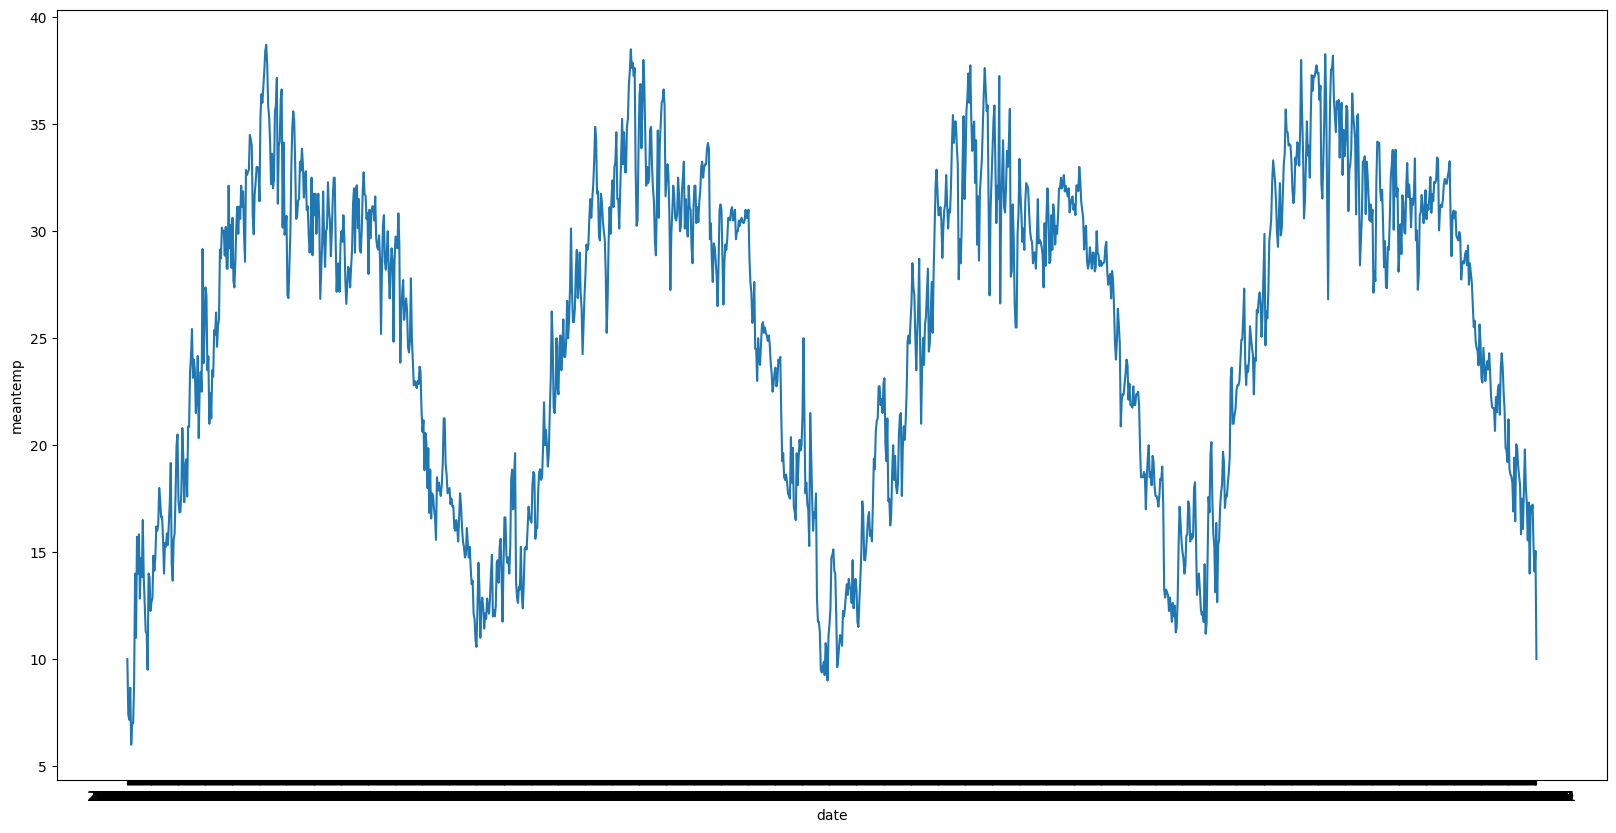

In [11]:
plt.rcParams["figure.figsize"] = (20,10)
fig = sns.lineplot(df_train,x="date",y="meantemp")

In [13]:
df_train.shape , df_test.shape

((1462, 5), (114, 5))

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
 5   year          1462 non-null   int64         
 6   month         1462 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 80.1 KB


In [16]:
df_train["date"] = pd.to_datetime(df_train["date"], format = '%Y-%m-%d')
df_train['year'] = df_train['date'].dt.year
df_train["month"] = df_train["date"].dt.month
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1


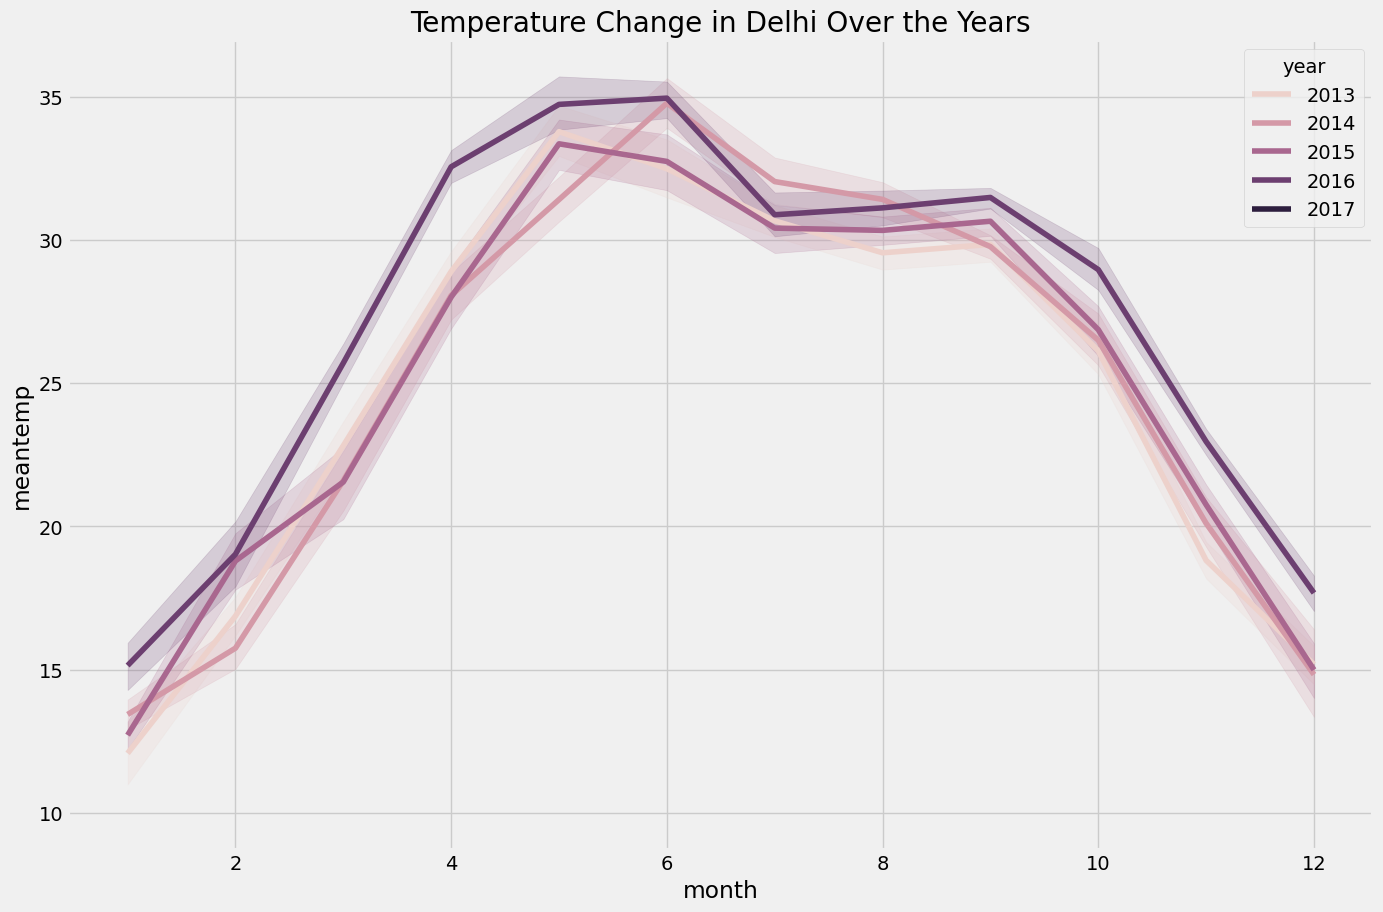

In [22]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.title("Temperature Change in Delhi Over the Years")
sns.lineplot(df_train, x='month', y='meantemp', hue='year')
plt.show()

In [23]:
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train , test , position

In [24]:
train , test , position = split_data(df_train,0.33)

In [25]:
print(train.shape,test.shape)

(980, 7) (482, 7)


In [29]:
train

,date,meantemp,humidity,wind_speed,meanpressure,year,month
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1
...,...,...,...,...,...,...,...
975,2015-09-03,31.625000,49.125000,10.187500,1005.500000,2015,9
976,2015-09-04,32.000000,42.625000,11.350000,1007.875000,2015,9
977,2015-09-05,30.875000,47.250000,7.637500,1007.125000,2015,9
978,2015-09-06,31.250000,41.800000,7.637500,1006.250000,2015,9


In [31]:
x = df_train.drop(["meantemp","year","month"],axis=1)
y = df_train["meantemp"]

In [37]:
x

,date,humidity,wind_speed,meanpressure
0,2013-01-01,84.500000,0.000000,1015.666667
1,2013-01-02,92.000000,2.980000,1017.800000
2,2013-01-03,87.000000,4.633333,1018.666667
3,2013-01-04,71.333333,1.233333,1017.166667
4,2013-01-05,86.833333,3.700000,1016.500000
...,...,...,...,...
1457,2016-12-28,68.043478,3.547826,1015.565217
1458,2016-12-29,87.857143,6.000000,1016.904762
1459,2016-12-30,89.666667,6.266667,1017.904762
1460,2016-12-31,87.000000,7.325000,1016.100000
